In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import datetime
import matplotlib.pyplot as plt

In [2]:
#  tickers and dates

tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'BRK-A', 'NVDA', 'V', 'JPM', 'UNH',
           'JNJ', 'BAC', 'WMT', 'PG', 'HD', 'MA', 'XOM', 'PFE', 'DIS', 'CVX',
           'KO', 'AVGO', 'PEP', 'CSCO', 'WFC', 'COST', 'LLY', 'ADBE']
start_time = datetime.datetime(2009, 12, 31) # 2009-12-31
end_time = datetime.datetime(2021, 12, 31) # 2021-12-31


In [3]:
# Contruction of X and Y
#The feature will be the asset and the Y the returns of the portfolio using the cap_weights

In [4]:
#Grap Market Capitalization for each stock in portfolio
cap_data = {}
for t in tickers:
    stock = yf.Ticker(t)
    cap_data[t] = stock.info["marketCap"]

In [5]:
cap_df = pd.DataFrame.from_dict(cap_data, orient='index', columns=['Market Cap'])
cap_df.index.name = 'Ticker'

In [6]:
#cap_data = pdr.get_quote_yahoo(tickers)['marketCap']
#cap_df = pd.DataFrame(cap_data)
cap_df['Weight'] = cap_df['Market Cap']/ cap_df['Market Cap'].sum()
cap_weights = np.array(cap_df['Weight'])

In [7]:
cap_weights

array([0.13589654, 0.14608336, 0.10037976, 0.09367326, 0.04182937,
       0.10727915, 0.0265522 , 0.02644221, 0.02189945, 0.01736347,
       0.01407988, 0.0233032 , 0.01876046, 0.01642241, 0.01993061,
       0.02530713, 0.00761128, 0.01007682, 0.01427453, 0.01294488,
       0.02862789, 0.01170481, 0.00922187, 0.01010019, 0.01594622,
       0.03376166, 0.01052739])

In [8]:
data = yf.download(tickers, start=start_time, end=end_time)['Adj Close']

[*********************100%%**********************]  27 of 27 completed


In [9]:
act_daily_ret_df=pd.DataFrame(index=data.index)
for ticker in tickers:
  # Get historical price data
  price_data = data[ticker]


  # Calculate daily returns
  returns = price_data.pct_change().dropna()

  #Adj daily_retun dataframe
  act_daily_ret_df[ticker]=returns

In [10]:
act_daily_ret_df = act_daily_ret_df.iloc[1:, :]

In [11]:
#To preprocess the data
def input_X_y(data,weight):
  X=[]; y=[]; a=0
  for i in range(len(data.index)):
    X.append(data.iloc[i])
    ri=X[i].dot(weight)
    y.append(np.sign(ri-a))
    a=ri
  return np.array(X), np.array(y)

In [12]:
# Function to optimize portfolio using Decision Tree
def optimize_portfolio_decision_tree(tickers, weight, start_date, end_date):
    # Fetch historical stock data
    #data = fetch_stock_data(tickers, start_date, end_date)
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']


    # Preprocess data
    #X, y = preprocess_data(data)
    X,y=input_X_y(act_daily_ret_df,weight)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Decision Tree model
    model = DecisionTreeClassifier()
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

    # Predict on the test set
    y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate feature importance as weights
    weights = model.feature_importances_
    #weights /= np.sum(weights)  # Normalize weights to sum up to 1

    return accuracy, weights

# Example usage
accuracy, weights = optimize_portfolio_decision_tree(tickers, cap_weights, start_time, end_time)
print("Decision Tree Portfolio Optimization Results:")
print("Accuracy:", accuracy)
print("Weights:", weights)

[*********************100%%**********************]  27 of 27 completed


Decision Tree Portfolio Optimization Results:
Accuracy: 0.6688741721854304
Weights: [0.04196865 0.18743468 0.03627603 0.02907831 0.04569438 0.08633368
 0.01850894 0.02684904 0.01320372 0.02335728 0.02731426 0.03369661
 0.02574617 0.03492935 0.04886075 0.03374778 0.01371473 0.03087932
 0.0122143  0.0258279  0.04275093 0.02048244 0.01957513 0.02520728
 0.01992934 0.02808264 0.04833638]


In [13]:
weights.sum()

1.0

In [14]:
#dataframe for daily portfolio returns
act_daily_port_ret_df = act_daily_ret_df.copy()
act_daily_port_ret_df.drop(columns=tickers, inplace=True)

In [15]:
#risk free return
risk_free_ret = 0.015

In [16]:
# function for adding different portfolios
def add_portfolio(portfolio, weights):
    act_daily_port_ret_df[f'{portfolio} Return'] = act_daily_ret_df.dot(weights)
    if portfolio == 'Pred':
        # upper bound of security transaction tax: 0.0003
        act_daily_port_ret_df[f'{portfolio} Return'] = act_daily_port_ret_df[f'{portfolio} Return'] - 0.0003
    act_daily_port_ret_df[f'{portfolio} Cum Prod Return'] = (1 + act_daily_port_ret_df[f'{portfolio} Return']).cumprod()

    exp_ret = act_daily_port_ret_df[f'{portfolio} Return'].mean()
    std = act_daily_port_ret_df[f'{portfolio} Return'].std()
    sharpe_ratio = (exp_ret - risk_free_ret) / std

    print(portfolio)
    print('Weights:')
    print(weights)
    print(f'Expected Return: {exp_ret:.6f}')
    print(f'Standard Dev   : {std:.6f}')
    print(f'Sharpe Ratio   : {sharpe_ratio:.6f}')

In [17]:
add_portfolio('Pred',weights)

Pred
Weights:
[0.04196865 0.18743468 0.03627603 0.02907831 0.04569438 0.08633368
 0.01850894 0.02684904 0.01320372 0.02335728 0.02731426 0.03369661
 0.02574617 0.03492935 0.04886075 0.03374778 0.01371473 0.03087932
 0.0122143  0.0258279  0.04275093 0.02048244 0.01957513 0.02520728
 0.01992934 0.02808264 0.04833638]
Expected Return: 0.000637
Standard Dev   : 0.011808
Sharpe Ratio   : -1.216318


In [18]:
n_assets = len(tickers)
eq_weights = np.ones(n_assets) / n_assets
add_portfolio('Eq', eq_weights)

Eq
Weights:
[0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704]
Expected Return: 0.000822
Standard Dev   : 0.010826
Sharpe Ratio   : -1.309621


In [19]:
add_portfolio('Cap', cap_weights)

Cap
Weights:
[0.13589654 0.14608336 0.10037976 0.09367326 0.04182937 0.10727915
 0.0265522  0.02644221 0.02189945 0.01736347 0.01407988 0.0233032
 0.01876046 0.01642241 0.01993061 0.02530713 0.00761128 0.01007682
 0.01427453 0.01294488 0.02862789 0.01170481 0.00922187 0.01010019
 0.01594622 0.03376166 0.01052739]
Expected Return: 0.001028
Standard Dev   : 0.012282
Sharpe Ratio   : -1.137601


In [20]:
add_portfolio('Pred_T',weights)

Pred_T
Weights:
[0.04196865 0.18743468 0.03627603 0.02907831 0.04569438 0.08633368
 0.01850894 0.02684904 0.01320372 0.02335728 0.02731426 0.03369661
 0.02574617 0.03492935 0.04886075 0.03374778 0.01371473 0.03087932
 0.0122143  0.0258279  0.04275093 0.02048244 0.01957513 0.02520728
 0.01992934 0.02808264 0.04833638]
Expected Return: 0.000937
Standard Dev   : 0.011808
Sharpe Ratio   : -1.190912


In [23]:
DT=pd.DataFrame(weights, index=tickers)
DT.to_csv('DT_weight.csv')

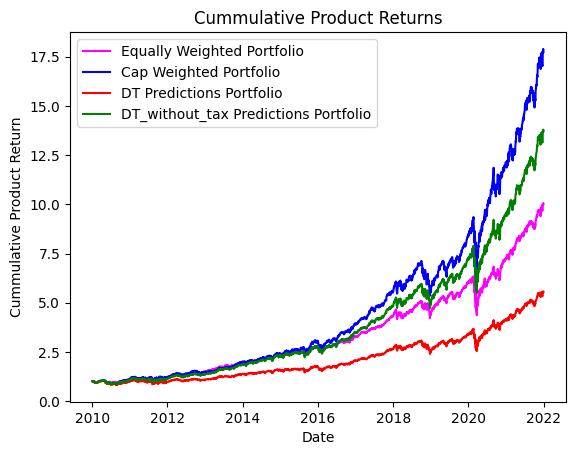

In [21]:
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Eq Cum Prod Return'],
         label='Equally Weighted Portfolio', color='fuchsia')
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Cap Cum Prod Return'],
         label='Cap Weighted Portfolio', color='blue')
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Pred Cum Prod Return'],
         label='DT Predictions Portfolio', color='red')
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Pred_T Cum Prod Return'],
         label='DT_without_tax Predictions Portfolio', color='g')
plt.xlabel('Date')
plt.ylabel('Cummulative Product Return')
plt.title('Cummulative Product Returns')
#plt.ylim(0.9, 2)
plt.legend()
plt.show()